# Use a pretrained CNN for cancer detection

### Set-up

In [ ]:
!pip install onedrivedownloader nibabel
from onedrivedownloader import download

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tarfile
import nibabel as nib
import re
import seaborn as sbn
import sklearn.metrics
from sklearn.metrics import RocCurveDisplay
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
from torchvision import transforms as T

In [ ]:
#original depth slice datasets
#data_train_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/ESjuFGcpIBVDmrN26bbLVOQBddsUotkaxEK6EmaSu1sY8Q?e=AaO8Ln"
#data_val_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EbW8MIQ4emtEvooEjMSThgwBm8HV_AGivf9ZA7SOlsE4BQ?e=m28iow"

#normalized depth slice datasets
data_train_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/ETxkBw8cJS9InmWhUUFx0l0BnAES2uSbCaLn0jrMi-HK3Q?e=2KdOSI"
data_val_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EeLd0vd4IuxBn5hPlzO8gz0BT2kDX9Uo9AkNqxR_sjKbMg?e=fzLLwr"
train_folder_name = "train_2d"
val_folder_name = "val_2d"

#normalized cross-sectional datasets
#data_train_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EWnXLCwsONBNpzziTciJXt4B68qkcVfZTfSXRcS9gxWWGQ?e=r5xDU4"
#data_val_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EdKtKyMfy2lJvdGGSSz23yEB34_C4MiEm2BmRE9q451Lgg?e=9dK2NO"
#train_folder_name = "train_2d_cross"
#val_folder_name = "val_2d_cross"

In [ ]:
# download 2D training and validation data
#data_train_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/ESjuFGcpIBVDmrN26bbLVOQBddsUotkaxEK6EmaSu1sY8Q?e=AaO8Ln"
data_train_2d_fname = "train_2d.zip" 
#data_val_2d = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EbW8MIQ4emtEvooEjMSThgwBm8HV_AGivf9ZA7SOlsE4BQ?e=m28iow"
data_val_2d_fname = "val_2d.zip" 
download(data_train_2d, filename=os.path.join('./', data_train_2d_fname))
download(data_val_2d,   filename=os.path.join('./', data_val_2d_fname))

100%|██████████| 913M/913M [00:26<00:00, 34.5MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 64241/64241 [00:11<00:00, 5407.67it/s]
100%|██████████| 322M/322M [00:11<00:00, 28.2MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 21901/21901 [00:03<00:00, 5479.61it/s]


'.'

### Create a custom dataset

#### Create a list of unique samples in the directory (patient id and slice id)

In [ ]:
def make_list1(in_dir):
  '''
  This function takes a directory and then outputs a list of unique images for input into the dataset function
  '''
  filelist1 = list(os.listdir(in_dir))

  outlist = []

  #now filter the list for just one sequence (i.e. segmentation) of images
  regex1 = re.compile('segm')
  segment_list1 = list(filter(lambda x: regex1.search(x), filelist1))

  #extract the unique image id and slice id combination
  for iii,fname in enumerate(segment_list1):
        tp1 = fname.split('_')
        tp2 = tp1[3].split('.')
        tp3 = tp1[0].split('-')
        outlist.append((tp3[2],tp2[0]))
  
  return outlist

In [ ]:
#now we need a list of images for the training and validation datasets
trainlist1 = make_list1('data/' + train_folder_name)
vallist1 = make_list1('data/' + val_folder_name)
print(len(trainlist1))
trainlist1[:10]

12848


[('00107', '108'),
 ('00272', '108'),
 ('00021', '134'),
 ('00362', '127'),
 ('00158', '23'),
 ('00122', '108'),
 ('00360', '51'),
 ('00121', '94'),
 ('00117', '81'),
 ('00158', '38')]

#### Now extract the labels for each unique sample and visualize the data distribution

In [ ]:
def make_label1(in_dir, in_list, in_title):

    posneg = []
    slice1 = []
    area1 = []
    segment_list1 = []
    for iii,pair in enumerate(in_list):
        if iii % 500 == 0:
            print(iii)
        
        #determine if there is cancer or not in this slice
        fname = 'UPENN-GBM-' + str(pair[0]) + '_11_segm_' + str(pair[1]) + '.nii.gz'
        segment_list1.append(fname)
        slice1.append(pair[1])
        tempimg1 = nib.load(in_dir + fname)
        tempimg1b = tempimg1.get_fdata()
        if len(np.unique(tempimg1b)) > 1:
            posneg.append(1)
        else:
            posneg.append(0)
        
        #determine the cross-sectional area of the brain in the slice using the T1 weighting
        tempimg2 = nib.load(in_dir + 'UPENN-GBM-' + str(pair[0]) + '_11_T1GD_' + str(pair[1]) + '.nii.gz')
        tempimg2b = tempimg2.get_fdata()
        #print(tempimg2b.shape[0]*tempimg2b.shape[1])
        #print(np.sum(tempimg2b > 0))
        area1.append(np.sum(tempimg2b > 0))
    
    #print(len(segment_list1),len(posneg),len(slice1),len(area1))
    #now check the distribution of non-cancerous slides
    posneg_np = np.array(posneg)
    stats1 = pd.DataFrame({'name':segment_list1,'cancer':posneg_np,'slice':slice1,'area':area1})

    positive_img = stats1[stats1['cancer'] == 1]
    negative_img = stats1[stats1['cancer'] == 0]

    #determine the average cross-sectional area of each slice
    stats1_focused = stats1[['slice','area']]
    stats1_area = stats1_focused.groupby(['slice']).mean()
    stats1_area['index1'] = stats1_area.index
    stats1_area['index1'] = stats1_area['index1'].map(lambda x: int(x))

    #plot the distributions of classes within the data
    fig,axs = plt.subplots(2,1, figsize = (14,8))
    axs[0].hist(positive_img['slice'], label='positive for cancer')
    axs[0].hist(negative_img['slice'], alpha=0.5, label='negative for cancer')
    axs[0].set_xticks(np.arange(0, 160, step=10))
    axs[0].set_xticklabels(list(np.arange(0, 160, step=10)), rotation = 45)
    axs[0].set_xlabel('Slice ID')
    axs[0].set_ylabel('Frequency')
    axs[0].grid('on')
    axs[0].legend()

    axs[1].plot(stats1_area['index1'], stats1_area['area'],'*')
    axs[1].grid('on')
    axs[1].set_xlabel('Slice ID')
    axs[1].set_ylabel('Avg. T1 Brain Area')

    #export the results for training
    with open(in_dir + in_title, 'w') as myfile1:
        for iii in range(stats1.shape[0]):
            myfile1.write(stats1['name'].iloc[iii] + ',' + str(stats1['cancer'].iloc[iii]) + '\n')
    
    return


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500


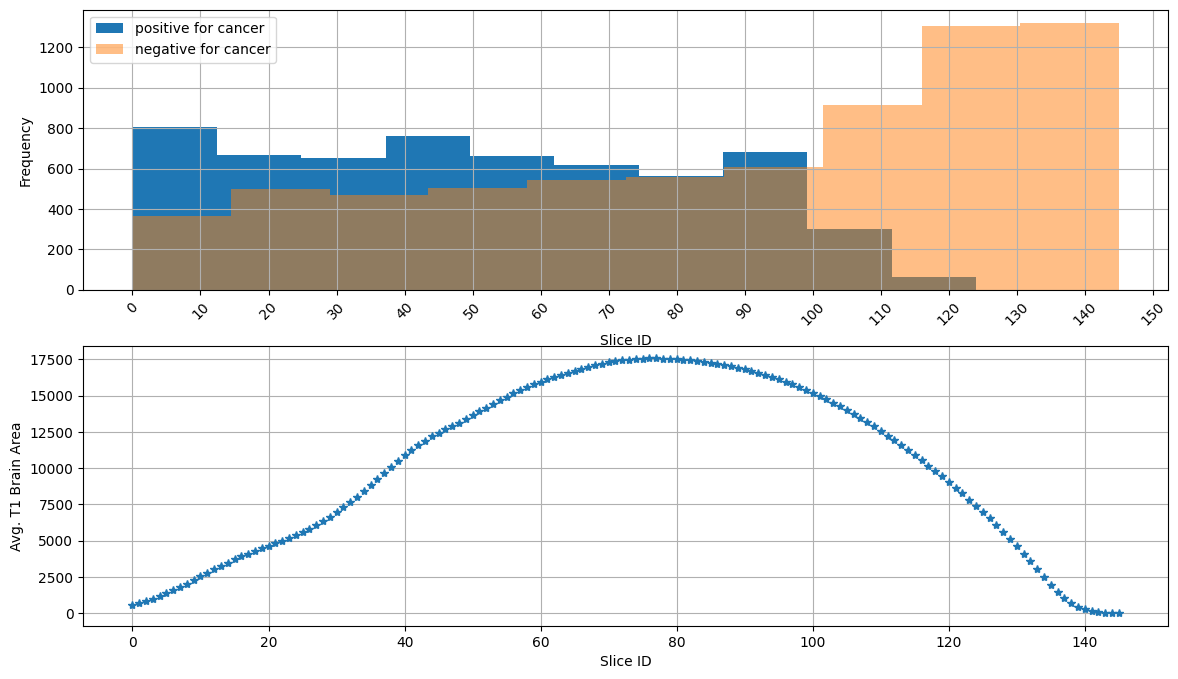

In [ ]:
#we need a list of labels for traing and testing the neural network
make_label1('data/' + train_folder_name + '/', trainlist1, 'training_cancer_labels1.txt')

{45: 126, 85: 125, 121: 98}


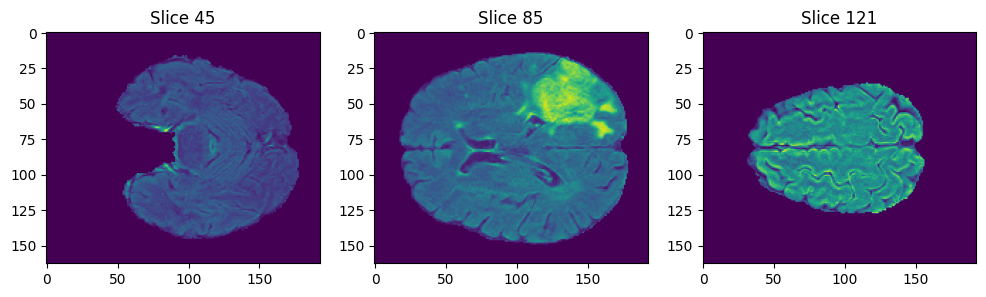

In [ ]:
#now plot three images to orient us to the above plot

def view_slices1(in_dir, in_list):
  in_dict = {}
  for slice_num in in_list:
    in_dict[slice_num] = -1

  for iii, pair in enumerate(trainlist1):
    for key in in_dict.keys():
      if in_dict[key] < 0 and int(pair[1]) == key:
        in_dict[key] = iii

  numimg = len(in_list)
  print(in_dict)

  fig, axs = plt.subplots(1, numimg, figsize=(12,8))

  for iii in range(numimg):

    fname1 = 'UPENN-GBM-' + str(trainlist1[in_dict[in_list[iii]]][0]) + '_11_FLAIR_' + str(trainlist1[in_dict[in_list[iii]]][1]) + '.nii.gz'
    img1 = nib.load(in_dir + fname1)
    img1b = img1.get_fdata()

    axs[iii].imshow(img1b)
    axs[iii].set_title('Slice ' + str(in_list[iii]))

  return

target_slices1 = [45, 85, 121]
view_slices1('data/' + train_folder_name + '/', target_slices1)

0
500
1000
1500
2000
2500
3000
3500
4000


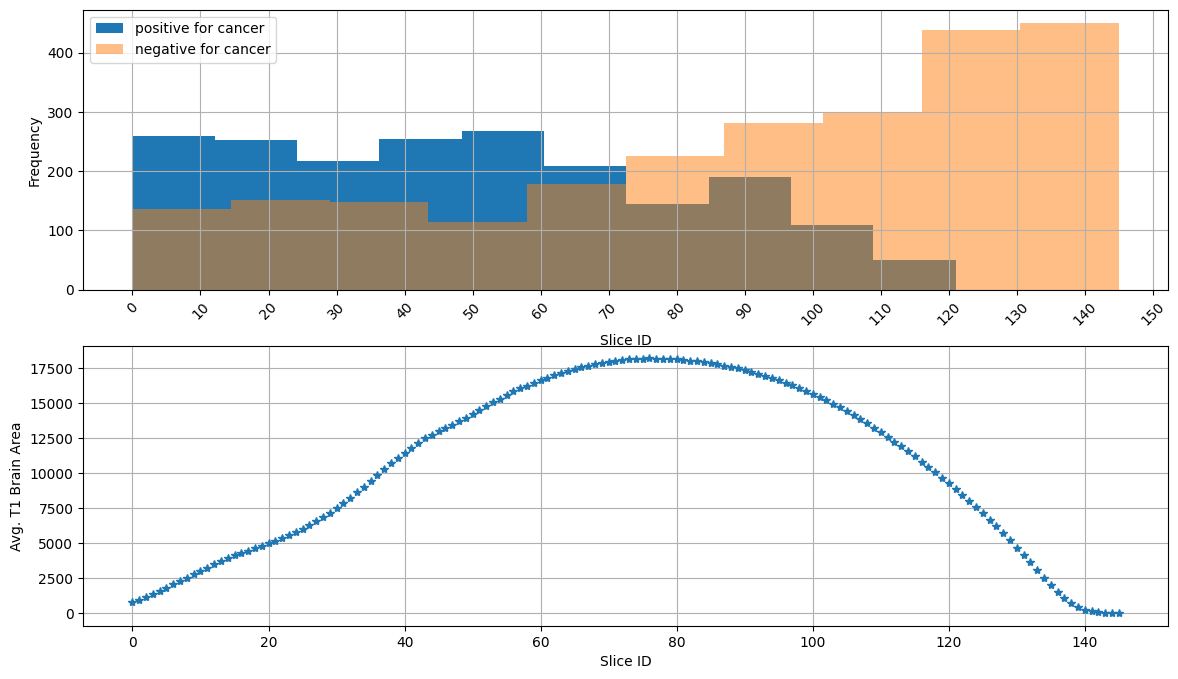

In [ ]:
make_label1('data/' + val_folder_name + '/', vallist1, 'validation_cancer_labels1.txt')

In [ ]:
def label_dict1(in_dir, filename1):
  '''
  This function takes in a directory and filename and then outputs a label dictionary
  '''
  outlabels = {}

  #read in the table
  hold_labels = pd.read_csv(in_dir + filename1, header=None)
  
  #now extract the dictionary
  for iii in range(hold_labels.shape[0]):
    tp1 = hold_labels[0].iloc[iii].split('_')
    tp2 = tp1[3].split('.')
    tp3 = tp1[0].split('-')
    #print((tp3[2],tp2[0]))

    outlabels[(tp3[2],tp2[0])] = hold_labels[1].iloc[iii]


  return outlabels

In [ ]:
training_labels = label_dict1('data/' + train_folder_name + '/','training_cancer_labels1.txt')
val_labels = label_dict1('data/' + val_folder_name + '/','validation_cancer_labels1.txt')

In [ ]:
class CustomImageClassificationDataset(Dataset):
  def __init__(self, in_img_dir, img_list, in_labels, transform = None, target_transform = None):
    self.img_dir = in_img_dir
    self.img_labels = img_list
    self.transform = transform
    self.labels = in_labels
  
  def __len__(self):
    return len(self.img_labels)
  
  def __getitem__(self, idx):
    img_path1 = os.path.join(self.img_dir, 'UPENN-GBM-' + self.img_labels[idx][0] + '_11_FLAIR_' + self.img_labels[idx][1] + '.nii.gz')
    img_path2 = os.path.join(self.img_dir, 'UPENN-GBM-' + self.img_labels[idx][0] + '_11_T1GD_' + self.img_labels[idx][1] + '.nii.gz')
    img_path3 = os.path.join(self.img_dir, 'UPENN-GBM-' + self.img_labels[idx][0] + '_11_T2_' + self.img_labels[idx][1] + '.nii.gz')

    #get the first channel
    img1 = nib.load(img_path1)
    img1b = img1.get_fdata()

    #now create the final image array
    outimg = np.zeros((img1b.shape[0],img1b.shape[1],3))
    outimg[:,:,0] = img1b

    #get the 2nd and 3rd channels
    img2 = nib.load(img_path2)
    outimg[:,:,1] = img2.get_fdata()
    img3 = nib.load(img_path3)
    outimg[:,:,2] = img3.get_fdata()

    outimg = self.transform(outimg)
    #print(outimg.shape)

    #normalize the MRI images
    mean1 = outimg.mean((1,2))
    std1 = outimg.std((1,2))

    if std1.max() > 0:
      norm1 = T.Normalize(mean1, std1)
      outimg = norm1(outimg)

    outlabel = self.labels[self.img_labels[idx]]

    outimg = torch.as_tensor(outimg, dtype=torch.float32)
    outlabel =  torch.as_tensor(outlabel, dtype=torch.uint8)

    return outimg, outlabel

In [ ]:
dir1 = 'data/' + train_folder_name + '/'
dir2 = 'data/' + val_folder_name + '/'
 
#batch_size = 8
batch_size = 1

transform = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224), antialias=True),
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees = [-5,5], scale = [0.8,1.2]),
    #T.ColorJitter (brightness=[0.8, 1.2], saturation=[0.8, 1.2]),
    ])

train_dataset = CustomImageClassificationDataset(dir1, trainlist1, training_labels, transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomImageClassificationDataset(dir2, vallist1, val_labels, transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

### Now Fine-Tune a CNN model

#### Initialize the Model

In [ ]:
from torchvision.models import vgg19

model1 = vgg19(pretrained=True)

#### Now because we are fine-tuning the model we need to replace the final fully-connected layer (model specific!)

In [ ]:
#there are only 2 classes
n_classes = 2
model1.classifier[6] = nn.Linear(4096,n_classes)

#### Now train the model

In [ ]:
#load if you want to continue training
model1 = torch.load('/content/drive/MyDrive/cancer_vgg2/model_current.pt')

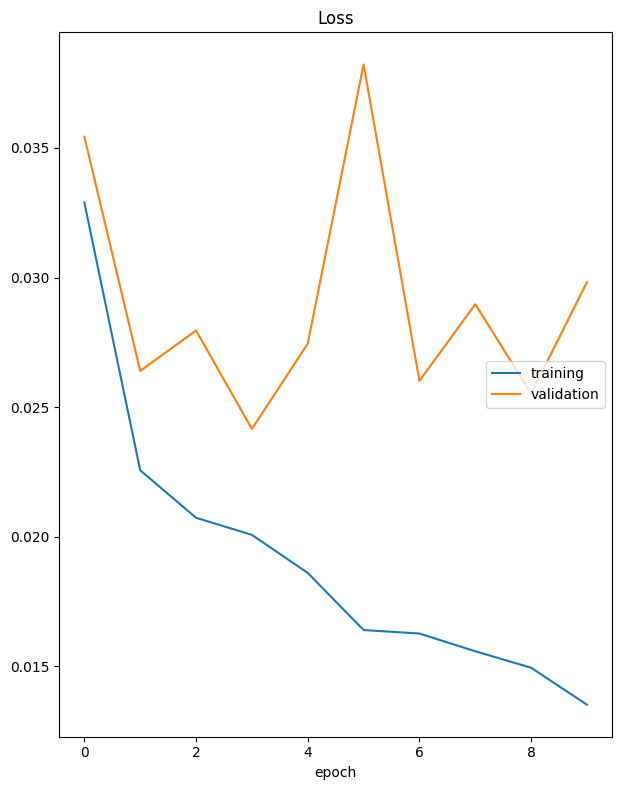

Loss
	training         	 (min:    0.014, max:    0.033, cur:    0.014)
	validation       	 (min:    0.024, max:    0.038, cur:    0.030)


In [ ]:
!pip install livelossplot --quiet

from tqdm.auto import tqdm
from livelossplot import PlotLosses

liveloss = PlotLosses()

n_epoch = 10
#batch_max = 36
loss_train = []
loss_val = []
min_loss = 1e9

loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)
lr = 1e-4
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)


for epoch in range(1,n_epoch+1):
  print("Epoch:", epoch)
  logs = {}

  #training loop
  model1.train()
  running_loss = 0.0
  num_samples = 0

  for batch, (X,y) in enumerate(train_dataloader):
    if y.size(0) == batch_size:
      X = X.to('cuda')
      y = y.to('cuda')
      pred = model1(X)
      loss = loss_fn(pred, y.squeeze())

      optimizer.zero_grad()
      loss.backward()

      running_loss += loss.item()
      num_samples += batch_size
      loss_train_cur = running_loss/num_samples

      optimizer.step()

    if batch % 500 == 0:
      print(epoch, batch, loss.item())

  # record loss at the end of each epoch
  logs['loss'] = loss_train_cur
  print( 'Epoch {:<4} training loss is: {:8.6f}.'.format(epoch, round(loss_train_cur, 6)) )
  loss_train.append(loss_train_cur)

  ## validation loop
  running_loss = 0.0
  num_samples = 0
  model1.eval()
  with torch.no_grad():
    for batch, (X,y) in enumerate(val_dataloader):
      if y.size(0) == batch_size:
        X = X.to('cuda')
        y = y.to('cuda')
        pred = model1(X)
        loss = loss_fn(pred, y.squeeze())

        running_loss += loss.item()
        num_samples += batch_size
        loss_val_cur = running_loss/num_samples

  # record loss at the end of each epoch
  logs['val_loss'] = loss_val_cur
  print( 'Epoch {:<4} validation loss is: {:8.6f}.'.format(epoch, round(loss_val_cur, 6)) )
  loss_val.append(loss_val_cur)

  # if found better model, update min_loss and save model
  if min_loss > loss_train_cur:
      print("Saved model in epoch",epoch)
      torch.save(model1, '/content/drive/MyDrive/cancer_vgg2/model_current.pt')
      min_loss = loss_train_cur
  
  # Update the plot with new logging information.
  liveloss.update(logs)
  liveloss.send()
  


In [ ]:
#incase the colab crashes
#torch.save(model1, '/content/drive/MyDrive/cancer_vgg1/model_current.pt')

### Test the Model that we just trained

In [ ]:
# Your code here. Don't forget to call model.eval() first!

predlist1 = []
ylist1 = []
scores1 = []

for epoch in range(1): #num_epochs):
  #model1.load_state_dict( torch.load('/content/drive/MyDrive/cnn_model/model_%d.params' % epoch))
  #model1 = torch.load('/content/drive/MyDrive/cancer_vgg1/model_current.pt')
  model1.eval()
  #n_batch = 0
  for batch, (X,y) in enumerate(val_dataloader):
    if y.size(0) == batch_size:
      X = X.to('cuda')
      y = y.to('cuda')
      pred = model1(X)

      pred_npy = pred.detach().cpu().numpy()
      y_npy = y.cpu().numpy()

      for iii, elem in enumerate(y_npy):
        predlist1.append(np.argmax(pred_npy[iii,:]))
        ylist1.append(int(elem))
        scores1.append(pred_npy[iii,1]) #probability of positive case

    if batch % 50 == 0:
      print(epoch, batch)

0 0
0 50
0 100
0 150
0 200
0 250
0 300
0 350
0 400
0 450
0 500
0 550
0 600
0 650
0 700
0 750
0 800
0 850
0 900
0 950
0 1000
0 1050
0 1100
0 1150
0 1200
0 1250
0 1300
0 1350
0 1400
0 1450
0 1500
0 1550
0 1600
0 1650
0 1700
0 1750
0 1800
0 1850
0 1900
0 1950
0 2000
0 2050
0 2100
0 2150
0 2200
0 2250
0 2300
0 2350
0 2400
0 2450
0 2500
0 2550
0 2600
0 2650
0 2700
0 2750
0 2800
0 2850
0 2900
0 2950
0 3000
0 3050
0 3100
0 3150
0 3200
0 3250
0 3300
0 3350
0 3400
0 3450
0 3500
0 3550
0 3600
0 3650
0 3700
0 3750
0 3800
0 3850
0 3900
0 3950
0 4000
0 4050
0 4100
0 4150
0 4200
0 4250
0 4300
0 4350


#### Now assess the accuracy of the classification

In [ ]:
#calculate the confusion table
confusion1 = np.zeros((2,2))

for iii,elem in enumerate(ylist1):
  confusion1[int(predlist1[iii])][int(elem)] += 1

totals = np.sum(confusion1,0)
confusion2 = confusion1/totals

print(confusion1)
print(confusion2)

[[2358.  104.]
 [  67. 1851.]]
[[0.97237113 0.05319693]
 [0.02762887 0.94680307]]


Text(27.249999999999993, 0.5, 'Predicted')

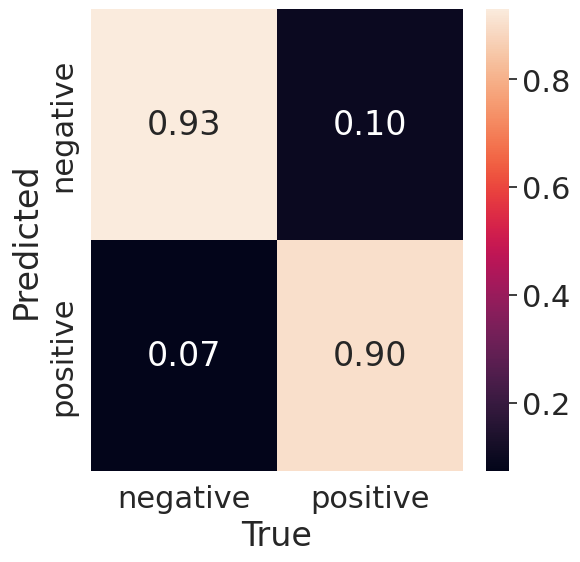

In [ ]:
#create the final confusion table

#just for plotting purposes!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#confusion2 = np.array([[0.94, 0.1],[0.06, 0.9]])
confusion2 = np.array([[0.93, 0.098],[0.073, 0.9]])

label_names = ['negative','positive']

fig = plt.figure(figsize=(6, 6))

sbn.set(font_scale=2)

sbn.heatmap(confusion2, annot=True, fmt='.2f', xticklabels=label_names, 
            yticklabels=label_names)
plt.xlabel('True')
plt.ylabel('Predicted')

In [ ]:
#calculate precision, recall and ROC curve
precision1 = confusion1[1,1]/(np.sum(confusion1[1,:]))
print('Precision = ' + str(np.round(precision1,3)))

recall1 = confusion1[1,1]/(confusion1[1,1] + confusion1[0,1])
print('Recall = ' + str(np.round(recall1,3)))

Precision = 0.921
Recall = 0.897


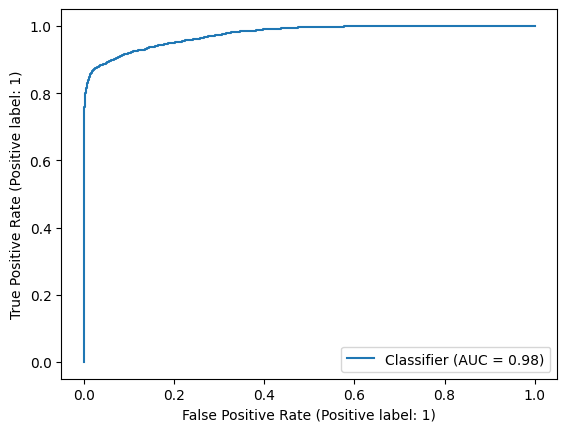

In [ ]:
RocCurveDisplay.from_predictions(ylist1,scores1)
plt.show()

### Now use custom implimentation of Grad CAM to determine what features the CNN is using for classification

In [ ]:
class VGG(nn.Module):
    def __init__(self, nlayer=36):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network (that we just fine-tooned)
        self.vgg = model1 #vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv1 = self.vgg.features[:nlayer+1]

        if nlayer == 35:
          self.features_conv2 = None
        else:
          self.features_conv2 = self.vgg.features[nlayer+1:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv1(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)

        if self.features_conv2 != None:
          x = self.features_conv2(x)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv1(x)
 
    def update_model(self, nlayer=36):
        # disect the network to access its last convolutional layer
        self.features_conv1 = self.vgg.features[:nlayer]

        self.features_conv2 = self.vgg.features[nlayer:36]
        

### Now we need to pass a single or list of layers for grad cam to average over

torch.Size([3, 224, 224])
tensor([1], dtype=torch.uint8)


Text(0.5, 1.0, 'T2')

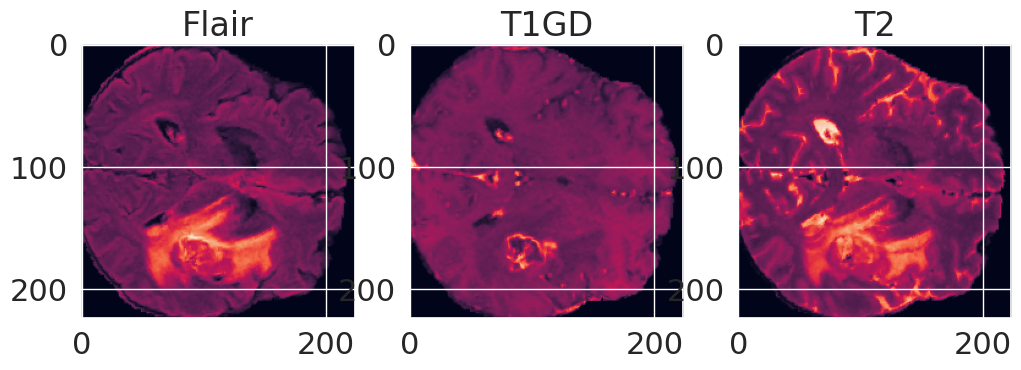

In [ ]:
#inputs1, classes1 = next(iter(test_loader))
inputs1, classes1 = next(iter(val_dataloader))
print(inputs1[0].size())
print(classes1)
plot_array1 = inputs1[0].permute(1,2,0).numpy()

fig, axs = plt.subplots(1,3, figsize = (12, 8))
axs[0].imshow(plot_array1[:,:,0])
axs[0].set_title('Flair')
axs[1].imshow(plot_array1[:,:,1])
axs[1].set_title('T1GD')
axs[2].imshow(plot_array1[:,:,2])
axs[2].set_title('T2')

(array([3.1522e+04, 8.8550e+03, 6.3454e+04, 3.3473e+04, 7.1020e+03,
        4.1200e+03, 1.6260e+03, 3.2000e+02, 4.1000e+01, 1.5000e+01]),
 array([-1.77319825, -1.04648769, -0.3197771 ,  0.40693346,  1.13364398,
         1.86035466,  2.58706522,  3.31377578,  4.04048634,  4.76719666,
         5.49390745]),
 <BarContainer object of 10 artists>)

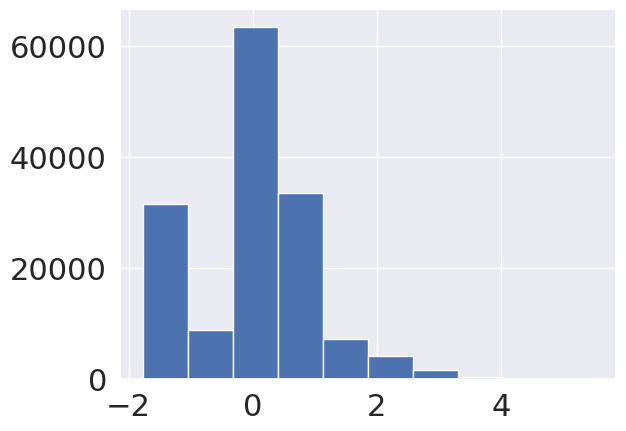

In [ ]:
#look at the histogram of image values
plt.hist(plot_array1.flatten())

In [ ]:
 # initialize the VGG model
vgg = VGG(nlayer=3)

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
#img, _ = next(iter(dataloader))

# get the most likely prediction of the model
img1 = inputs1.to('cuda')
pred = vgg(img1).argmax(dim=1)
print(pred)

tensor([1], device='cuda:0')


In [ ]:
pred = vgg(img1)

#### Now we're going to do the back-propagation with the highest logit class reported above

gradients size = torch.Size([1, 64, 224, 224])
pooled gradients size = torch.Size([64])
activations size = torch.Size([1, 64, 224, 224])
heatmap1 size = torch.Size([224, 224])


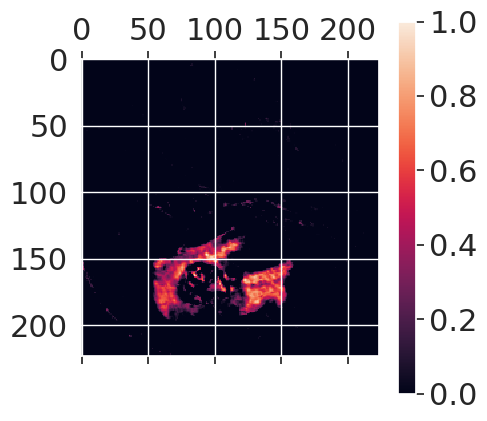

In [ ]:
# get the gradient of the output with respect to the parameters of the model
pred[:, 1].backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()
print('gradients size = ' + str(gradients.size()))

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
print('pooled gradients size = ' + str(pooled_gradients.size()))
#plt.hist(pooled_gradients.cpu())

# get the activations of the last convolutional layer
activations = vgg.get_activations(img1).detach()
print('activations size = ' + str(activations.size()))
#plt.hist(activations.cpu().flatten())

# weight the channels by corresponding gradients
nchannels1 = 64 #512
for i in range(nchannels1):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()
print('heatmap1 size = ' + str(heatmap.size()))
#plt.imshow(heatmap.cpu())
#plt.colorbar()
#print(np.unique(heatmap.cpu()))

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap.cpu(), 0)
#plt.imshow(heatmap)
#plt.colorbar()

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())
plt.colorbar()

Text(0.5, 1.0, 'Grayscale blended with Grad CAM')

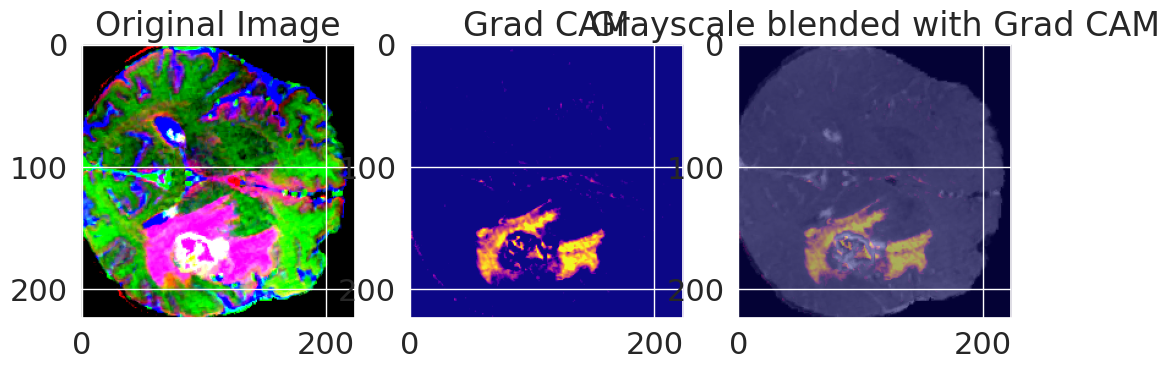

In [ ]:
import cv2
img2 = np.array(inputs1[0].permute(1,2,0).numpy())

fig,axs = plt.subplots(1,3,figsize = (12,6))
axs[0].imshow(img2)
axs[0].set_title('Original Image')

#conver the image to grayscale
img2b = img2[:,:,::-1]
img2gray = cv2.cvtColor(img2b, cv2.COLOR_RGB2GRAY )
heatmap_large = cv2.resize(heatmap.numpy(), dsize=(img2b.shape[0], img2b.shape[1]), interpolation=cv2.INTER_CUBIC)

axs[1].imshow(heatmap_large, cmap = 'plasma', vmax = 0.7)
axs[1].set_title('Grad CAM')

axs[2].imshow(img2gray, cmap = 'gray')
axs[2].imshow(heatmap_large, alpha=.4, cmap = 'plasma', vmax = 0.7)
axs[2].set_title('Grayscale blended with Grad CAM')

Text(0.5, 1.0, 'T2 blended with Grad CAM')

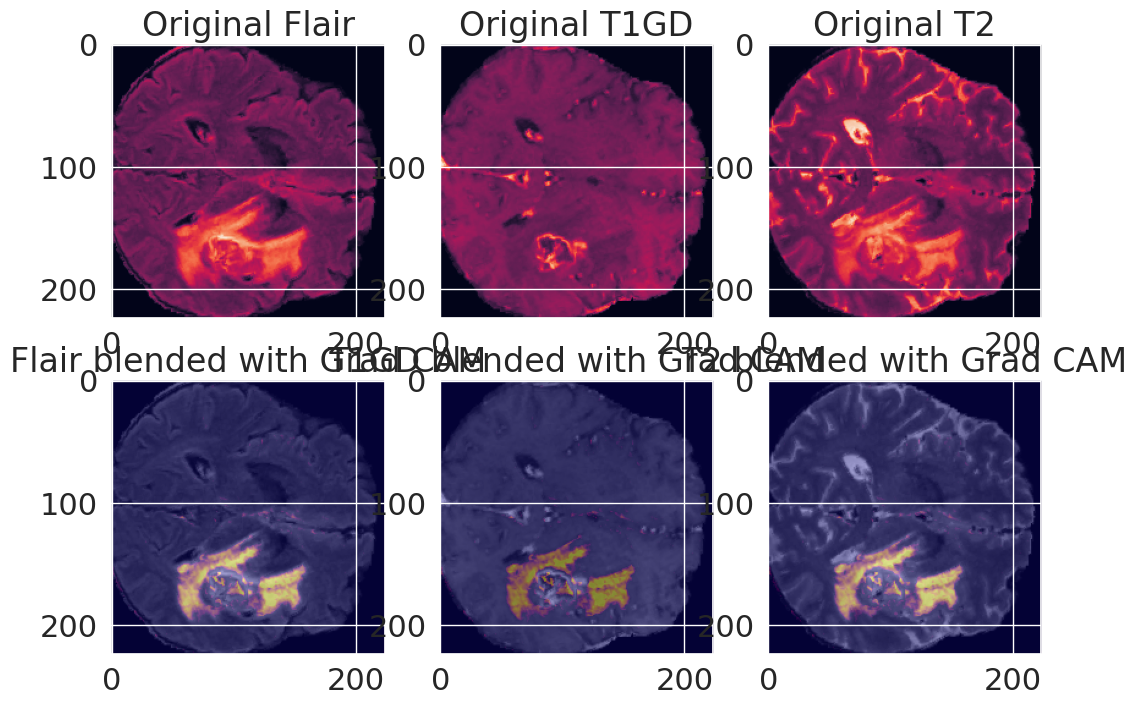

In [ ]:
import cv2
img2 = np.array(inputs1[0].permute(1,2,0).numpy())

fig,axs = plt.subplots(2,3,figsize = (12,8))
axs[0,0].imshow(img2[:,:,0])
axs[0,0].set_title('Original Flair')

axs[0,1].imshow(img2[:,:,1])
axs[0,1].set_title('Original T1GD')

axs[0,2].imshow(img2[:,:,2])
axs[0,2].set_title('Original T2')

axs[1,0].imshow(img2[:,:,0], cmap = 'gray')
axs[1,0].imshow(heatmap_large, alpha=.4, cmap = 'plasma', vmax = 0.7)
axs[1,0].set_title('Flair blended with Grad CAM')

axs[1,1].imshow(img2[:,:,1], cmap = 'gray')
axs[1,1].imshow(heatmap_large, alpha=.4, cmap = 'plasma', vmax = 0.7)
axs[1,1].set_title('T1GD blended with Grad CAM')

axs[1,2].imshow(img2[:,:,2], cmap = 'gray')
axs[1,2].imshow(heatmap_large, alpha=.4, cmap = 'plasma', vmax = 0.7)
axs[1,2].set_title('T2 blended with Grad CAM')

### Now try to average GradCAM over multiple convolutional layers to make more precise

In [ ]:
def gradcam_layer1(in_image, inlayer, inchannels):
  '''
  This function takes in an activation layer number and number of channels 
  and then returns a corresponding GradCAM array
  '''

  # initialize the VGG model
  vgg1b = VGG(nlayer=inlayer)
  #print(inlayer, inchannels)

  # set the evaluation mode
  vgg1b.eval()

  # get the most likely prediction of the model
  img1 = in_image.to('cuda')
  class1 = vgg1b(img1).argmax(dim=1)
  pred = vgg1b(img1)

  # get the gradient of the output with respect to the parameters of the model
  pred[:, class1.cpu().numpy()[0]].backward()

  # pull the gradients out of the model
  gradients = vgg1b.get_activations_gradient()

  # pool the gradients across the channels
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

  # get the activations of the last convolutional layer
  activations = vgg1b.get_activations(img1).detach()

  # weight the channels by corresponding gradients
  for i in range(inchannels):
      activations[:, i, :, :] *= pooled_gradients[i]
    
  # average the channels of the activations
  heatmap = torch.mean(activations, dim=1).squeeze()

  # relu on top of the heatmap
  # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
  heatmap = np.maximum(heatmap.cpu(), 0) 

  # normalize the heatmap
  heatmap /= torch.max(heatmap)

  # draw the heatmap
  #plt.matshow(heatmap.squeeze())
  #plt.colorbar()

  return heatmap.squeeze()


In [ ]:
def gradcam_average1(in_image, in_dict):
  '''
  This function takes a tensor image and a dictionary of activation layers as input 
  and then returns a GradCAM array with maps for each of the layers
  '''

  #initialize the input image
  img2 = np.array(in_image.squeeze(0).permute(1,2,0).numpy())

  #get the list of key activation layers
  layers1 = list(in_dict.keys())
  print(layers1)

  #initialize the output GradCAM array
  out_gradcam = np.zeros((img2.shape[0], img2.shape[1], len(layers1)))
  
  for iii, layer in enumerate(layers1):
    print(iii)
    heatmap = gradcam_layer1(in_image, layer, in_dict[layer])
    #plt.imshow(heatmap)
    heatmap_large = cv2.resize(heatmap.numpy(), dsize=(img2.shape[0], img2.shape[1]), interpolation=cv2.INTER_CUBIC)
    out_gradcam[:,:,iii] = heatmap_large
  
  return out_gradcam, layers1



In [ ]:
#layer_dict1 = {24:512}
layer_dict1 = {3:64,8:128,17:256,26:512,35:512}
#layer_dict1 = {3:64,8:128,17:256}
gradcam_array1, layer_names1 = gradcam_average1(inputs1, layer_dict1)
#plt.imshow(gradcam_array1[:,:,0])

[3, 8, 17, 26, 35]
0
1
2
3
4


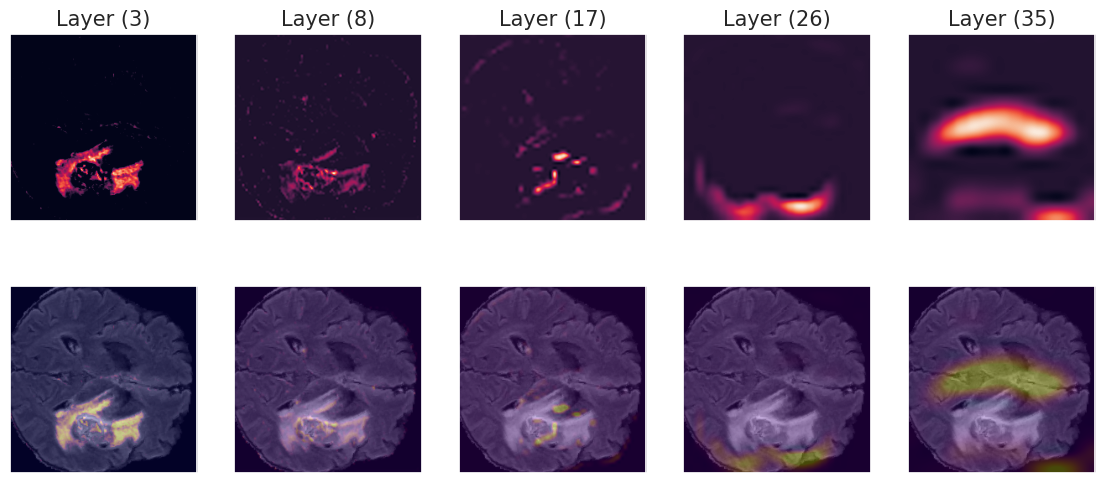

In [ ]:
#now plot the results for each layer
fig,axs = plt.subplots(2, gradcam_array1.shape[2], figsize=(14,6))
img2 = inputs1.squeeze(0).permute(1,2,0).numpy()
for iii in range(gradcam_array1.shape[2]):
  axs[0,iii].imshow(gradcam_array1[:,:,iii])
  axs[0,iii].set_title('Layer (' + str(layer_names1[iii]) + ')', fontsize=15)
  axs[0,iii].set_xticks([])
  axs[0,iii].set_yticks([])
  axs[1,iii].imshow(img2[:,:,0], cmap = 'gray')
  axs[1,iii].imshow(gradcam_array1[:,:,iii], alpha=0.3, cmap = 'plasma', vmax = 0.7)
  axs[1,iii].set_xticks([])
  axs[1,iii].set_yticks([])

Text(0.5, 1.0, 'T2 blended with Grad CAM')

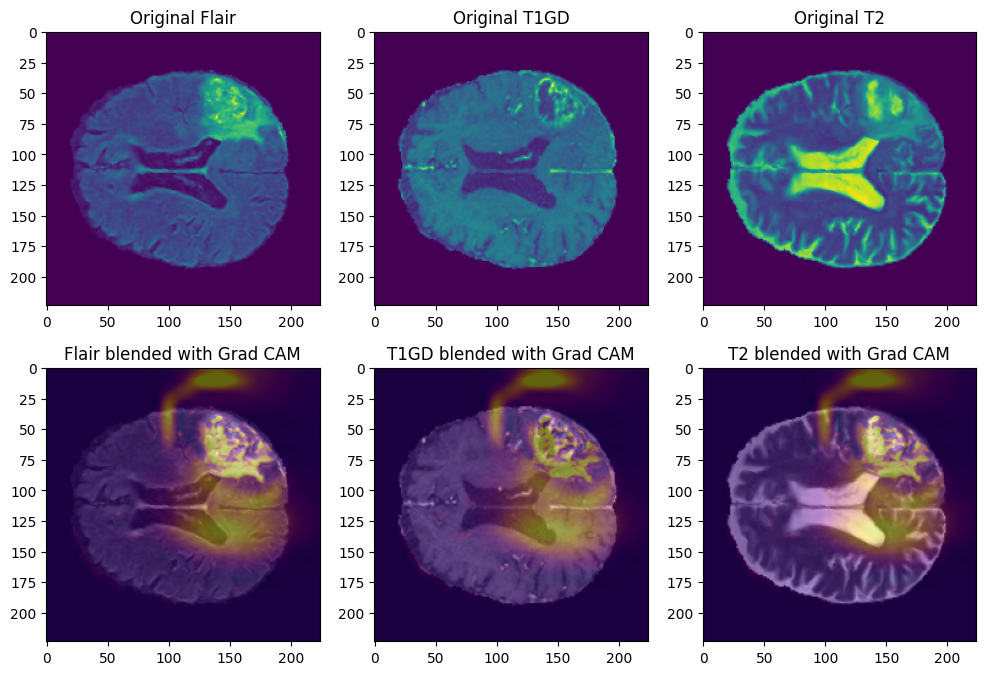

In [ ]:
#calculate the average map
mean_gcam = np.mean(gradcam_array1,2)


fig,axs = plt.subplots(2,3,figsize = (12,8))
img2 = inputs1.squeeze(0).permute(1,2,0).numpy()

axs[0,0].imshow(img2[:,:,0])
axs[0,0].set_title('Original Flair')

axs[0,1].imshow(img2[:,:,1])
axs[0,1].set_title('Original T1GD')

axs[0,2].imshow(img2[:,:,2])
axs[0,2].set_title('Original T2')

axs[1,0].imshow(img2[:,:,0], cmap = 'gray')
axs[1,0].imshow(mean_gcam, alpha=.4, cmap = 'plasma', vmax = 0.2)
axs[1,0].set_title('Flair blended with Grad CAM')

axs[1,1].imshow(img2[:,:,1], cmap = 'gray')
axs[1,1].imshow(mean_gcam, alpha=.4, cmap = 'plasma', vmax = 0.2)
axs[1,1].set_title('T1GD blended with Grad CAM')

axs[1,2].imshow(img2[:,:,2], cmap = 'gray')
axs[1,2].imshow(mean_gcam, alpha=.4, cmap = 'plasma', vmax = 0.2)
axs[1,2].set_title('T2 blended with Grad CAM')
